# Initialisation

In [23]:
from __future__ import annotations
import numpy as np
from sympy.combinatorics import GrayCode
from collections.abc import Iterable
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
from scipy.special import erfc
from commpy.filters import rrcosfilter
from commpy.utilities import upsample
from eyediagram.mpl import eyediagram


NUM_PAM_BITS = 1
PAM_OUTPUT_LOWER = -1
PAM_OUTPUT_UPPER = 1
SYMBOL_RATE_S = 2e-6
RAISED_COSINE_FILTER_ROLLOFF_FACTOR = 0.18
RAISED_COSINE_FILTER_WINDOW_SIZE = 6
OVERSAMPLING_FACTOR = 8
CHANNEL_CUTOFF_HZ = 500e3
ENERGY_PER_BIT_TO_NOISE_POWER_SPECTRAL_DENSITY_DB = 10
ENERGY_PER_BIT_TO_NOISE_POWER_SPECTRAL_DENSITY_DB_START = 0
ENERGY_PER_BIT_TO_NOISE_POWER_SPECTRAL_DENSITY_DB_STOP = 10
NUM_ENERGY_PER_BIT_TO_NOISE_POWER_SPECTRAL_DENSITY_DB = 20
EXAMPLE_USER_DATA = np.array([1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0])
NOISE_RNG_SEED = 0
EYE_DIAGRAM_INPUT_LENGTH = 1_000_000

# Question D

## PAM Modulator

In [24]:
class PulseAmplitudeModulator:
    """A modulator that encodes and decodes using the pulse amplitude modulation scheme"""

    output_lower: float
    output_upper: float
    code_length: int
    code_word_to_amplitude_map: dict[tuple[int, ...], float] = {}
    amplitude_to_code_word_map: dict[float, tuple[int, ...]] = {}

    def __init__(self, output_lower: float, output_upper: float, code_length: int):
        """
        @param output_lower the lowest value the modulator will output
        @param output_upper the highest value the modulator will output
        @param code_length the length of the code in bits (log2 of 'n' in n-PAM)
        """
        self.output_lower = output_lower
        self.output_upper = output_upper
        self.code_length = code_length

        gray_code_strings = GrayCode(code_length).generate_gray()

        # Map the gray codes to an amplitude value
        for code_i, code_string in enumerate(gray_code_strings):
            code = tuple(int(b) for b in code_string)
            amplitude = self.amplitude_from_code_index(code_i)
            self.code_word_to_amplitude_map[code] = amplitude
            self.amplitude_to_code_word_map[amplitude] = code

    def encode(self, input_signal: Iterable[int]) -> list[float]:
        """Encode the input signal into an n-PAM signal"""
        partitioned_signal = self.split_signal_into_chunks_of_code_length(input_signal)

        result: list[float] = []
        for input_bitstring in partitioned_signal:
            result.append(self.code_word_to_amplitude_map[input_bitstring])

        return result

    def decode(self, received_signal: Iterable[float]) -> list[int]:
        """Decodes the n-PAM signal"""
        decoded_signal = []
        for amplitude in received_signal:
            code_word = self.decode_symbol(amplitude)
            decoded_signal.extend(code_word)

        return decoded_signal

    def decode_symbol(self, symbol_amplitude: float) -> tuple[int, ...]:
        """Decodes a single n-PAM symbol"""
        code_amplitudes = np.array(list(self.amplitude_to_code_word_map.keys()))
        closest_amplitude_i = np.abs(code_amplitudes - symbol_amplitude).argmin()
        closest_amplitude = code_amplitudes[closest_amplitude_i]

        code_word = self.amplitude_to_code_word_map[closest_amplitude]
        return code_word

    def split_signal_into_chunks_of_code_length(
        self, signal: Iterable[int]
    ) -> list[tuple[int, ...]]:
        """Converts a binary signal into an n-ary binary signal"""
        partitioned_signal = np.split(signal, signal.size / self.code_length)

        result: list[tuple[int, ...]] = []
        for code_word in partitioned_signal:
            result.append(tuple(code_word))

        return result

    def amplitude_from_code_index(self, idx: int) -> float:
        """Retrieves the amplitude corresponding to an index of a codeword"""
        amplitude = np.interp(
            idx, [0, 2**self.code_length - 1], [self.output_lower, self.output_upper]
        )

        return amplitude

    def compute_bit_energy(self):
        """Calculates the bit energy of the n-PAM code"""
        code_amplitudes = np.array(list(self.code_word_to_amplitude_map.values()))
        code_energy = np.sum(np.square(code_amplitudes))

        bit_energy = code_energy / (code_amplitudes.size * self.code_length)
        return bit_energy

## Root-Raised-Cosine Filter 

In [25]:
class RootRaisedCosineFilter:
    """Represents a root raised cosine filter than can filter and unfilter signals"""

    symbol_period: float
    resolution: int
    impulse_response: np.array[float]
    impulse_time: np.array[float]

    def __init__(
        self,
        symbol_period: float,
        roll_off_factor: float = 0.5,
        resolution=50,
        window_length: float = 6,
    ):
        """
        @param resolution the number of samples per symbol
        @param window_length the length of the impulse response window in symbol periods
        """
        self.symbol_period = symbol_period
        self.resolution = resolution
        self.impulse_time, self.impulse_response = rrcosfilter(
            window_length * self.resolution,
            roll_off_factor,
            symbol_period,
            resolution / symbol_period,
        )
        impulse_response_energy = np.sum(np.square(self.impulse_response))
        self.impulse_response /= np.sqrt(impulse_response_energy)

    def filter(
        self, input_signal: Iterable[float]
    ) -> tuple[np.ndarray[np.float], np.ndarray[np.float]]:
        """Filters the input signal using the root raised cosine filter"""

        convolution_input = np.real(upsample(input_signal, self.resolution))
        
        output_values = np.convolve(convolution_input, self.impulse_response)

        # Compute the time index of the output values
        time_values = (
            np.arange(len(output_values)) * self.symbol_period / self.resolution
            + self.impulse_time.min()
        )

        return time_values, output_values

    def unfilter(self, input_signal: np.ndarray[np.float]) -> np.ndarray[np.float]:
        """Pass an input signal through a matched root raised cosine filter"""

        # Compute the time-reversed impulse response
        time_reversed_impulse_response = self.impulse_response[::-1]

        unfiltered_signal = np.convolve(
            input_signal, time_reversed_impulse_response, mode="same"
        )

        return unfiltered_signal

PAM encoding the example signal:

In [26]:
pulse_amplitude_modulator = PulseAmplitudeModulator(
    PAM_OUTPUT_LOWER, PAM_OUTPUT_UPPER, NUM_PAM_BITS
)

pam_encoded_example_signal = pulse_amplitude_modulator.encode(EXAMPLE_USER_DATA)
pam_encoded_example_signal

[1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0]

Filtering the modulated example signal:

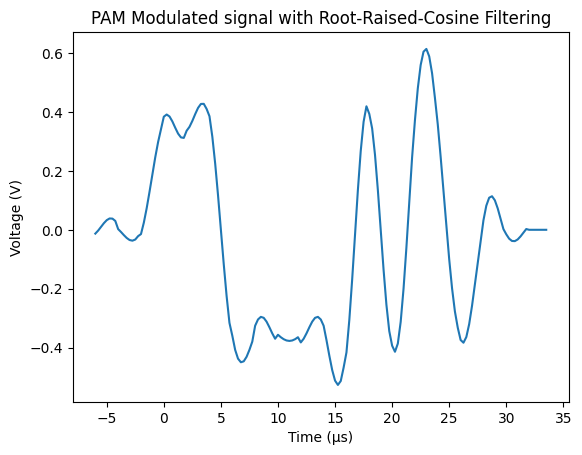

In [27]:
raised_cosine_filter = RootRaisedCosineFilter(
    SYMBOL_RATE_S,
    RAISED_COSINE_FILTER_ROLLOFF_FACTOR,
    OVERSAMPLING_FACTOR,
    RAISED_COSINE_FILTER_WINDOW_SIZE,
)
time, filtered_example_signal = raised_cosine_filter.filter(pam_encoded_example_signal)
time_us = time * 1e6

fig, ax = plt.subplots()

ax.plot(time_us, filtered_example_signal)
ax.set_title("PAM Modulated Signal with Root-Raised-Cosine Filtering")
ax.set_ylabel("Voltage (V)")
ax.set_xlabel("Time (μs)");

# Question E

## Band-Limited Channel

In [28]:
class BandLimitedChannel:
    """Represents a channel limited in bandwidth"""

    cutoff_frequency: float
    rng: np.random.Generator

    def __init__(
        self,
        cutoff_frequency: float,
        sample_spacing: float,
        noise_power: float,
        rng_seed: int | None = None,
    ):
        self.cutoff_frequency = cutoff_frequency
        self.sample_spacing = sample_spacing
        self.noise_power = noise_power
        self.rng = np.random.default_rng(rng_seed)

    def transmit_signal(self, signal: Iterable[float]) -> np.ndarray[float]:
        signal_spectrum = fft(signal)
        frequencies = fftfreq(len(signal), self.sample_spacing)

        passband_mask = frequencies <= self.cutoff_frequency

        signal_spectrum_filtered = signal_spectrum.copy()
        signal_spectrum_filtered[~passband_mask] = 0

        signal_filtered = ifft(signal_spectrum_filtered)

        awg_noise = np.sqrt(self.noise_power) * self.rng.standard_normal(len(signal))

        noisy_signal = np.real(signal_filtered) + awg_noise
        return noisy_signal

Passing the signal through the matched filter, plotting the output:

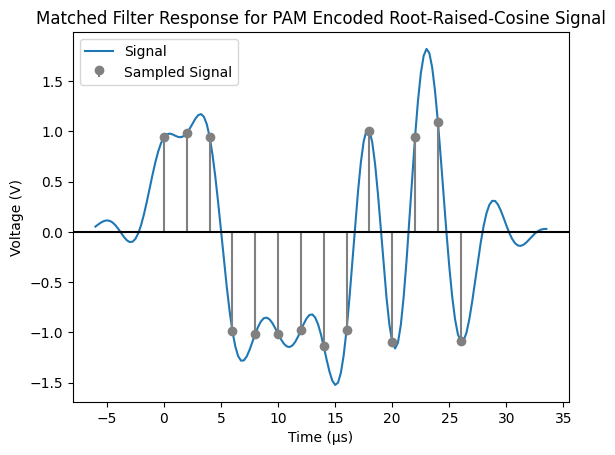

In [29]:
unfiltered_example_signal = raised_cosine_filter.unfilter(filtered_example_signal)

region_of_interest = (time >= 0) & (
    time < SYMBOL_RATE_S * len(pam_encoded_example_signal)
)
sampling_times_us = time_us[region_of_interest][::OVERSAMPLING_FACTOR]
sampled_amplitudes = unfiltered_example_signal[region_of_interest][
    ::OVERSAMPLING_FACTOR
]

fig, ax = plt.subplots()

ax.plot(time_us, unfiltered_example_signal, label="Signal")
ax.stem(
    sampling_times_us,
    sampled_amplitudes,
    label="Sampled Signal",
    linefmt="grey",
    basefmt=" ",
)

ax.axhline(color="black")
ax.set_title("Matched Filter Response for PAM Encoded Root-Raised-Cosine Signal")
ax.set_ylabel("Voltage (V)")
ax.set_xlabel("Time (μs)")
ax.legend();

Generating and displaying the eye diagram at the output of the matched filter:

/tmp/ipykernel_68779/1836988759.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(-2, 2, 0.5))


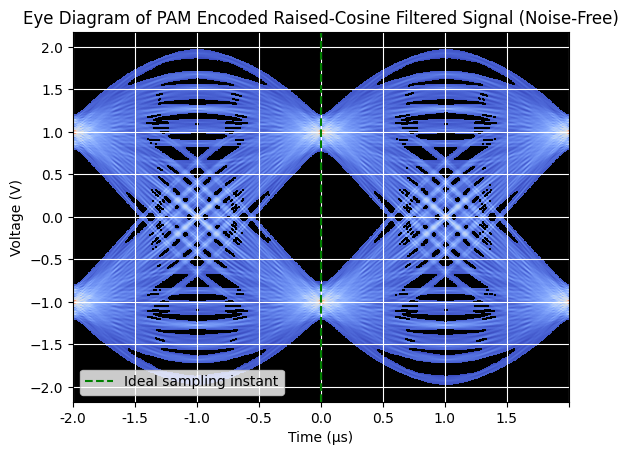

In [30]:
eye_diagram_input_signal = np.random.randint(0, 2, EYE_DIAGRAM_INPUT_LENGTH)
pam_encoded_eye_diagram_signal = pulse_amplitude_modulator.encode(
    eye_diagram_input_signal
)
time, eye_diagram_filtered_signal = raised_cosine_filter.filter(
    pam_encoded_eye_diagram_signal
)

band_limited_channel = BandLimitedChannel(
    CHANNEL_CUTOFF_HZ, SYMBOL_RATE_S / OVERSAMPLING_FACTOR, 0
)

eye_diagram_band_limited_signal = band_limited_channel.transmit_signal(
    eye_diagram_filtered_signal
)

unfiltered_signal = raised_cosine_filter.unfilter(eye_diagram_band_limited_signal)

fig, ax = plt.subplots()

eyediagram(
    unfiltered_signal,
    2 * OVERSAMPLING_FACTOR,
    colorbar=False,
    aspect="auto",
    cmap=plt.cm.coolwarm,
)

ax.set_xticklabels(np.arange(-2, 2, 0.5))

ax.axvline(1, color="green", linestyle="dashed", label="Ideal sampling instant")
ax.set_title("Eye Diagram of PAM Encoded Raised-Cosine Filtered Signal (Noise-Free)")
ax.set_ylabel("Voltage (V)")
ax.set_xlabel("Time (μs)")
ax.legend(loc="lower left");

# Question F

In [31]:
def watts_from_db(db: float) -> float:
    """Converts a power in dB to a power in Watts"""
    return 10 ** (db / 10)

Generating and displaying the eye diagram at the output of the matched filter in the presence of noise:

/tmp/ipykernel_68779/230710071.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(-2, 2, 0.5))


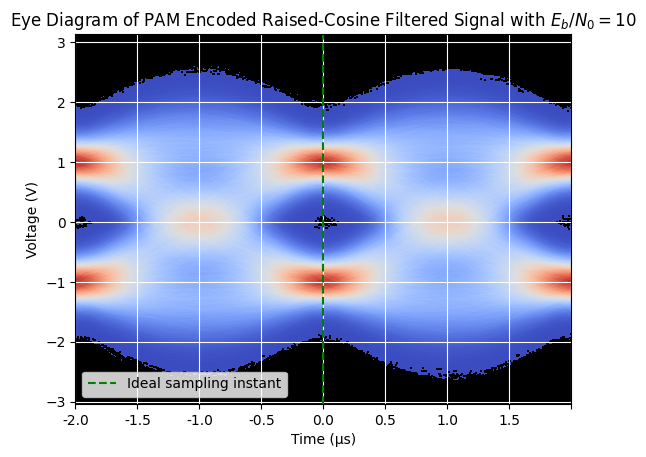

In [32]:
energy_per_bit_to_noise_power_spectral_density_watts = watts_from_db(
    ENERGY_PER_BIT_TO_NOISE_POWER_SPECTRAL_DENSITY_DB
)

noise_power_watts = 1 / (2 * energy_per_bit_to_noise_power_spectral_density_watts)

band_limited_channel = BandLimitedChannel(
    CHANNEL_CUTOFF_HZ, SYMBOL_RATE_S / OVERSAMPLING_FACTOR, noise_power_watts
)

eye_diagram_band_limited_signal = band_limited_channel.transmit_signal(
    eye_diagram_filtered_signal
)

unfiltered_signal = raised_cosine_filter.unfilter(eye_diagram_band_limited_signal)

fig, ax = plt.subplots()

eyediagram(
    unfiltered_signal,
    2 * OVERSAMPLING_FACTOR,
    colorbar=False,
    aspect="auto",
    cmap=plt.cm.coolwarm,
)
ax.set_xticklabels(np.arange(-2, 2, 0.5))

ax.axvline(1, color="green", linestyle="dashed", label="Ideal sampling instant")
ax.set_title(
    f"Eye Diagram of PAM Encoded Raised-Cosine Filtered Signal with $E_b/N_0 = {ENERGY_PER_BIT_TO_NOISE_POWER_SPECTRAL_DENSITY_DB}$"
)
ax.set_xlabel("Time (μs)")
ax.set_ylabel("Voltage (V)")
ax.legend(loc="lower left");

# Question H

Finding, computing and plotting the bit error rate for a range of noise power spectral densities:

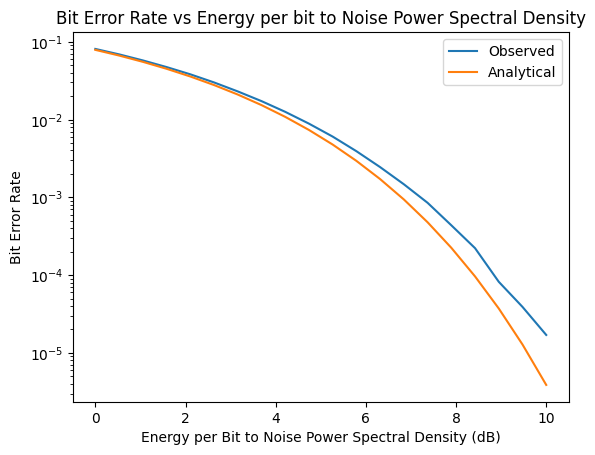

In [33]:
noise_spectral_densities_db = np.linspace(
    ENERGY_PER_BIT_TO_NOISE_POWER_SPECTRAL_DENSITY_DB_START,
    ENERGY_PER_BIT_TO_NOISE_POWER_SPECTRAL_DENSITY_DB_STOP,
    NUM_ENERGY_PER_BIT_TO_NOISE_POWER_SPECTRAL_DENSITY_DB,
)

observed_bit_error_rates = []
analytical_bit_error_rates = []

# Find and compute the bit error rate for each energy per bit to noise power spectral density
for energy_per_bit_to_noise_spectral_density_db in noise_spectral_densities_db:
    energy_per_bit_to_noise_power_spectral_density_watts = watts_from_db(
        energy_per_bit_to_noise_spectral_density_db
    )

    noise_power_watts = 1 / (2 * energy_per_bit_to_noise_power_spectral_density_watts)
    band_limited_channel = BandLimitedChannel(
        CHANNEL_CUTOFF_HZ,
        SYMBOL_RATE_S / OVERSAMPLING_FACTOR,
        noise_power_watts,
        NOISE_RNG_SEED,
    )
    band_limited_signal = band_limited_channel.transmit_signal(
        eye_diagram_filtered_signal
    )
    unfiltered_signal = raised_cosine_filter.unfilter(band_limited_signal)

    region_of_interest = (time >= 0) & (
        time < SYMBOL_RATE_S * len(pam_encoded_eye_diagram_signal)
    )
    sampled_amplitudes = unfiltered_signal[region_of_interest][::OVERSAMPLING_FACTOR]
    decoded_signal = pulse_amplitude_modulator.decode(sampled_amplitudes)
    bit_error_count = np.count_nonzero(
        np.not_equal(decoded_signal, eye_diagram_input_signal)
    )
    observed_bit_error_rates.append(bit_error_count / len(eye_diagram_input_signal))

    analytical_bit_error_rate = 0.5 * erfc(
        np.sqrt(energy_per_bit_to_noise_power_spectral_density_watts)
    )
    analytical_bit_error_rates.append(analytical_bit_error_rate)

# Plot the bit error rate vs the energy per bit to noise power spectral density
fig, ax = plt.subplots()

ax.plot(noise_spectral_densities_db, observed_bit_error_rates, label="Observed")
ax.plot(noise_spectral_densities_db, analytical_bit_error_rates, label="Analytical")

ax.set_yscale("log", base=10)
ax.set_ylabel("Bit Error Rate")
ax.set_xlabel("Energy per Bit to Noise Power Spectral Density (dB)")
ax.set_title("Bit Error Rate vs Energy per bit to Noise Power Spectral Density")
ax.legend();